## Введение

Дано:
Заказчик - оператор связи.

Заказчик предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

У нашего заказичка уходят клиенты, по каким причинам не понятно.

Заказчик предоставил 4 файла с данными:

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Передомной стоит задача классификации, мне необходимо определить уйдет клиент или нет. Для этого будем использовать модели вида classifier

Какие результаты хотим получить:

- Анализ какие клиенты уходят
- Предсказать по текущим данным может ли клиент от нас уйти.
- Точность модели предсказания > .85 UAC-ROC

## Импорт кода

In [1]:
try:
    import pandas_profiling
except:
    !pip install pandas_profiling
    import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
import phik

from phik.report import plot_correlation_matrix
from phik import report
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score

## Загрузка данных

In [2]:
df = {}

try:
    df['contract'] = pd.read_csv('/datasets/final_provider/contract.csv', 
                             parse_dates=['BeginDate', 'EndDate'])
    df['personal'] = pd.read_csv('/datasets/final_provider/personal.csv')
    df['internet'] = pd.read_csv('/datasets/final_provider/internet.csv')
    df['phone'] = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    df['contract'] = pd.read_csv(r'E:\Trash\contract.csv', parse_dates=['BeginDate', 'EndDate'])
    df['personal'] = pd.read_csv(r'E:\Trash\personal.csv')
    df['internet'] = pd.read_csv(r'E:\Trash\internet.csv')
    df['phone'] = pd.read_csv(r'E:\Trash\phone.csv')

In [3]:
for i in df:
    print('Table: ', i)
    display(pandas_profiling.ProfileReport(df[i]))
    display(100*'*')

Table:  contract


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

'****************************************************************************************************'

Table:  personal


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

'****************************************************************************************************'

Table:  internet


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

'****************************************************************************************************'

Table:  phone


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

'****************************************************************************************************'

Таблица contract:
- 7043 наблюдения
- Явных пропусков нет
- Явных дублей нет
- Требуется преобразовать EndDate к типу Дата
- Требуется преобразовать TotalCharges к Типу float
- TotalCharges содержит пустые значения строкового типа

Таблица personal
- 7043 наблюдения
- янвых пропусков нет
- явных дублей нет
- Требуется преобразовать SeniorCitizen к типу Boolean

Таблица internet
- 5517 наблюдений
- явных пропусков нет
- явных дублей нет
- ошибки форматов данных нет

Таблица phone
- 6361 наблюдение
- явных пропусков нет
- явных дублей нет
- ошибки форматов данных нет

Пользователь может потреблять услуги как или интернета, или телефонии, так и все вместе.
Целевой признак можно получить из таблицы contract по признаку EndDate = No.

## Анализ качества данных

### Наименования колонок

In [4]:
for i in df:
    print('Table: ', i)
    display(df[i].columns)
    display(100*'*')

Table:  contract


Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

'****************************************************************************************************'

Table:  personal


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

'****************************************************************************************************'

Table:  internet


Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

'****************************************************************************************************'

Table:  phone


Index(['customerID', 'MultipleLines'], dtype='object')

'****************************************************************************************************'

- Во всех таблицах поменять customerID на CustomerID
- В таблице personal поменять gender на Gender

### Анализ TotalCharges

In [5]:
_df = df['contract']
print('Пустых:',len(_df[_df['TotalCharges']==' ']))

Пустых: 11


### Выводы

- Во всех таблицах поменять customerID на CustomerID
- В таблице personal поменять gender на Gender
- Требуется преобразовать EndDate к типу Дата
- Требуется преобразовать TotalCharges к Типу float
- Требуется преобразовать SeniorCitizen к типу Boolean
- Добавить целевой признак

## Исправление данных

### Наименование колонок

In [6]:
for i in df:
    df[i].rename(columns={"customerID": "CustomerID"}, inplace=True)
    
    if i == 'personal':
        df[i].rename(columns={"gender": "Gender"}, inplace=True)

### Целевой признак

In [7]:
_df = df['contract']
_df['Target'] = (_df['EndDate'] != 'No').astype(int)

### Типы данных

In [8]:
#EndDate
_df = df['contract']
_df.loc[_df['EndDate']=='No', 'EndDate'] = '2020-02-01 00:00:00'
_df['EndDate'] = pd.to_datetime(_df['EndDate'])

#TotalCharges
_df.loc[_df['TotalCharges'] == ' ', 'TotalCharges'] = 0
_df['TotalCharges'] = _df['TotalCharges'].astype(float)

#SeniorCitizen
_df = df['personal']
_df['SeniorCitizen'] = _df['SeniorCitizen'].astype(bool)

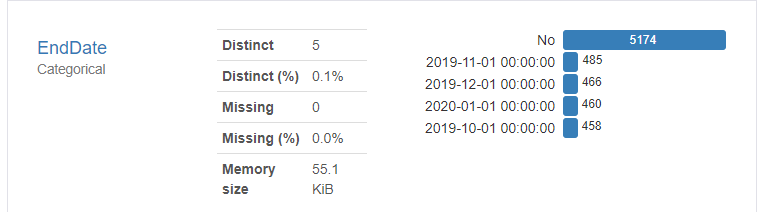

### Выводы

- Во всех таблицах были переименованы колонки customerID на CustomerID
- В таблице personal была переименована колонка gender на Gender
- Были преобразованы данные EndDate к типу Дата
- Были преобразованы данные TotalCharges к Типу float
- Были преобразованы данные SeniorCitizen к типу Boolean
- Был добавлен целевой признак в колонку Target

## Объединение данных

In [9]:
f_df = df['contract'].merge(df['personal'], on='CustomerID')
f_df = f_df.merge(df['internet'], on='CustomerID', how='left')
f_df = f_df.merge(df['phone'], on='CustomerID', how='left')

In [10]:
display(f_df.shape)
f_df.isna().sum()

(7043, 21)

CustomerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Target                 0
Gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

- Записи все на месте.
- Кроме колонки InternetService, все остальные бинарные, поэтому заполним их значением No.
- Пропуски в колонке InternetService заполним значением "No service"

In [11]:
f_df['InternetService'] = f_df['InternetService'].fillna('No service')

In [12]:
columns_list = ['OnlineSecurity','OnlineBackup','DeviceProtection',
               'TechSupport','StreamingTV','StreamingMovies','MultipleLines']
f_df[columns_list] = f_df[columns_list].fillna('No')

## Анализ данных

### Добавление данных

In [13]:
# добавим время жизни абонента
f_df['LifetimeCustomer'] = (f_df['EndDate']-f_df['BeginDate']).dt.days.astype(int)

In [14]:
# сдлаем набор для последующей кластеризации
a_df = f_df.copy()
a_df = a_df.drop(labels=['CustomerID','BeginDate','EndDate', 'Target'],axis=1)

encode_list =['Type','PaperlessBilling','PaymentMethod',
              'Gender','Partner','Dependents','InternetService',
              'OnlineSecurity','OnlineBackup','DeviceProtection',
              'TechSupport','StreamingTV','StreamingMovies','MultipleLines','SeniorCitizen']
#a_df = a_df.drop(labels=encode_list,axis=1)

enc = OrdinalEncoder()
a_df[encode_list] = enc.fit_transform(a_df[encode_list])

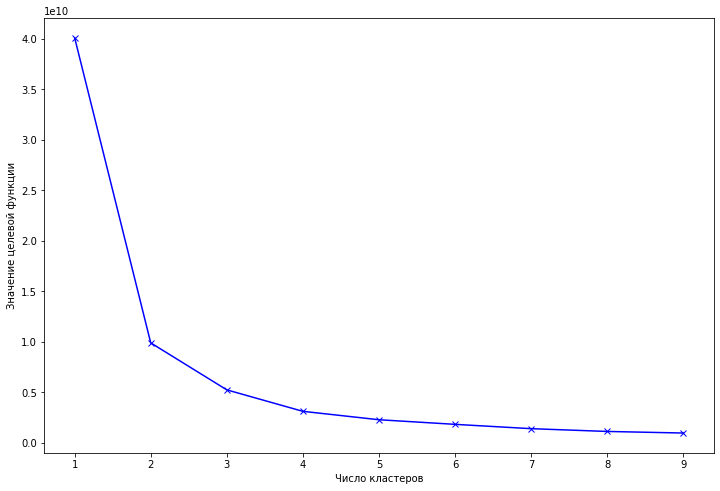

In [15]:
K = range(1, 10)
distortion = []
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(a_df)
    distortion.append(model.inertia_) 
    
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

In [16]:
model = KMeans(n_clusters=4, random_state=12345)
model.fit(a_df)

class_df = pd.DataFrame(model.cluster_centers_.round(), columns=a_df.columns)
display(class_df)

f_df['Class'] = model.predict(a_df)

Type  PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  \
0   0.0               1.0            2.0            51.0         381.0   
1   1.0               1.0            1.0           100.0        6631.0   
2   1.0               1.0            1.0            56.0        1779.0   
3   1.0               1.0            1.0            82.0        4094.0   

   Gender  SeniorCitizen  Partner  Dependents  InternetService  \
0     0.0            0.0      0.0         0.0              1.0   
1     0.0            0.0      1.0         0.0              1.0   
2     1.0            0.0      1.0         0.0              1.0   
3     1.0            0.0      1.0         0.0              1.0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  \
0             0.0           0.0               0.0          0.0          0.0   
1             1.0           1.0               1.0          1.0          1.0   
2             0.0           0.0               0.0          0.0          0.0   
3             0.0           1.0               1.0          0.0          1.0   

   StreamingMovies  MultipleLines  LifetimeCustomer  
0              0.0            0.0             273.0  
1              1.0            1.0            2019.0  
2              0.0            0.0            1181.0  
3              1.0            1.0            1574.0

### Исследовательский

In [17]:
def visual_data_catplot(x,kind='box',orient='h'):    
    g = sns.catplot(y='Target', x=x, kind=kind, 
                    data=f_df, 
                    orient=orient, palette = 'pastel')
    g.set_yticklabels(["Оставшиеся", "Ушедшие"])
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)
    plt.show()
    display(f_df.loc[f_df['Target']==1, x].describe())
    
def visual_data_personal(list_data):

    for i in list_data:
        g = sns.histplot(data=f_df, x=i, hue="Target", palette = 'pastel')
        g.legend_.set_title(i)
        new_labels = ["Оставшиеся", "Ушедшие"]

        for t, l in zip(g.legend_.texts, new_labels):
            t.set_text(l)
        plt.show()
        
def visual_alldata_catplot(x):    
    g = sns.boxplot(x=f_df[x])
    g.figure.set_figwidth(16)
    g.figure.set_figheight(2)
    plt.show()
    display(f_df.loc[:, x].describe())

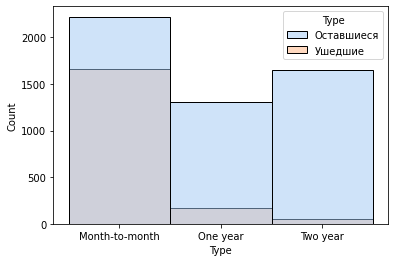

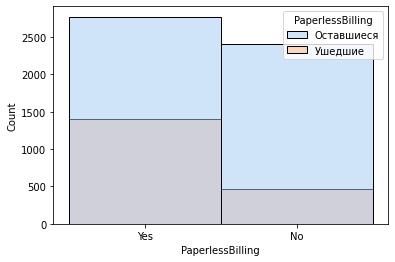

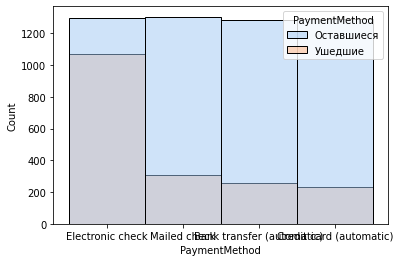

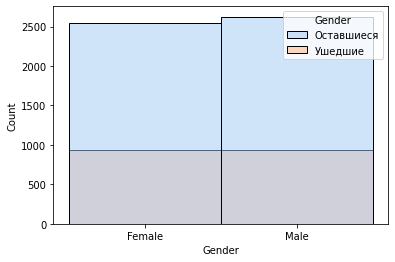

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


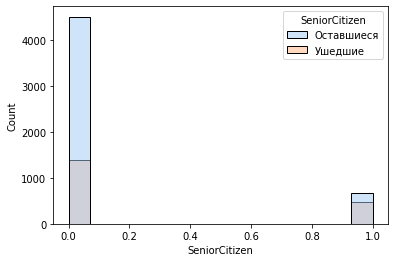

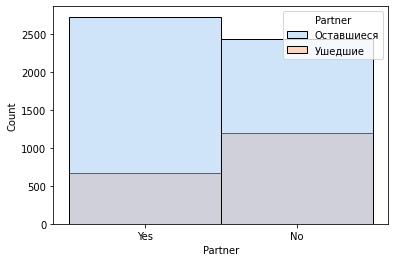

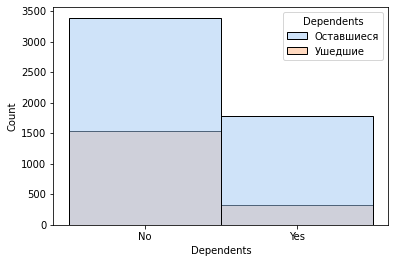

In [18]:
info_list = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents']
visual_data_personal(info_list)

- Большая часть ушедших использует услуги с ежемесячной оплатой.
- Большая часть ушедших использует безналичный расчет
- Большая часть ушедших использует электронные чеки как способ оплаты
- Пол не влият на вероятность ухода
- Большая часть ушедших имеет пенсионный статус
- У большей части ушедших нет супруга
- У большей части ушедших есть иждивенцы

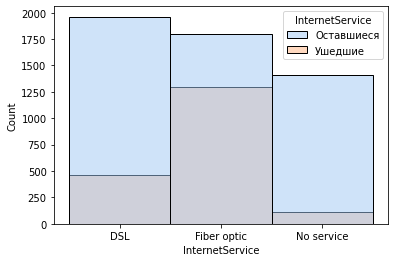

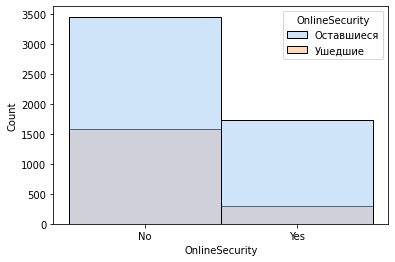

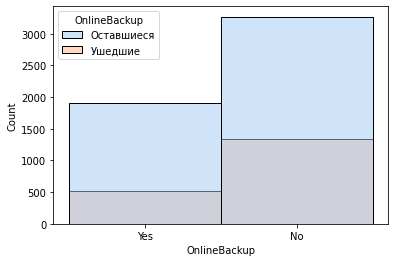

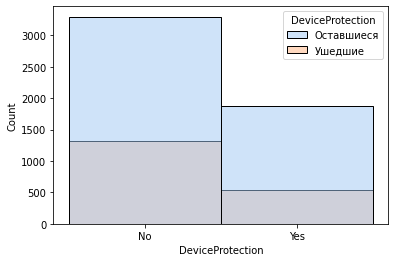

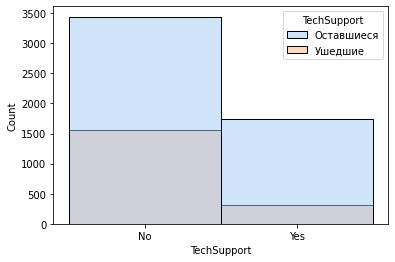

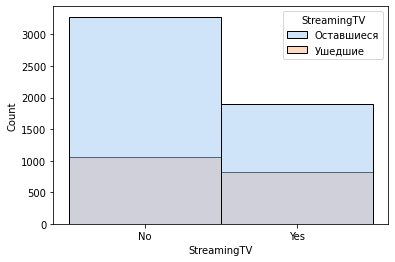

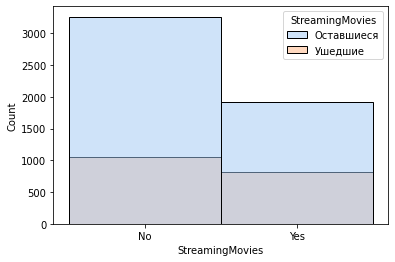

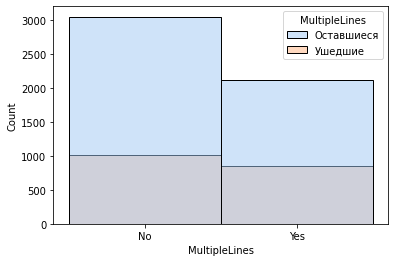

In [19]:
service_list = ['InternetService', 'OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies','MultipleLines']
visual_data_personal(service_list)

- Большая часть ушедших использует оптоволоконный интернет
- Большая часть ушедших не используется онлайн защиту
- Большая часть ушедших не использует онлайн резервное копирование
- Большая часть ушедших не используется защиту устройств
- Большая часть ушедших не использует тех поддержку.
- Чуть больше половины ушедших не используется ТВ
- Чуть больше половины ушедших не испольуется сервис кино
- Чуть больше половины ушедших не использую множественную линию

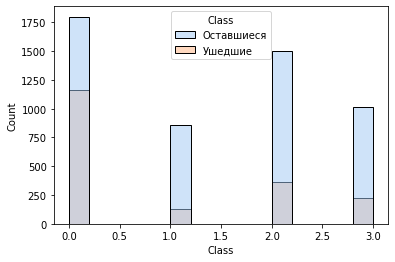

In [20]:
info_list = ['Class']
visual_data_personal(info_list)

Большая часть ушедших относится к 1 категории, которая характеризуется средним ежемесячным платежом в 51 у.е., общим доходом 381 у.е. и временем жизни клиента в 273 дня

### Статистический

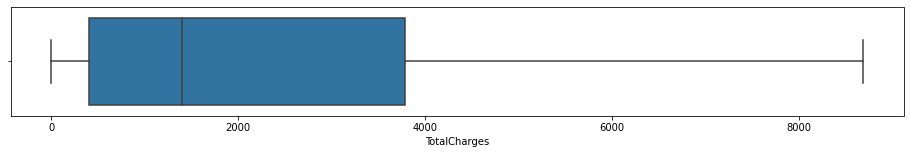

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

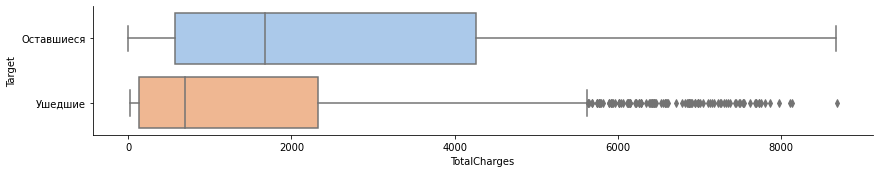

count    1869.000000
mean     1531.796094
std      1890.822994
min        18.850000
25%       134.500000
50%       703.550000
75%      2331.300000
max      8684.800000
Name: TotalCharges, dtype: float64

In [21]:
visual_alldata_catplot('TotalCharges')
visual_data_catplot('TotalCharges')

В среднем ушедший принес компании от 134 до 2331 у.е., средний пользователь приносит от 398 до 3786 у.е

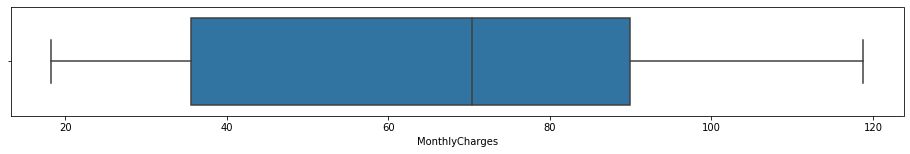

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

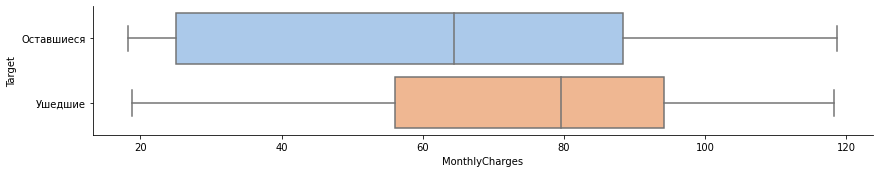

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [22]:
visual_alldata_catplot('MonthlyCharges')
visual_data_catplot('MonthlyCharges')

В среднем пользователь платит от 35 до 89 у.е. в месяц, ушедшие платят от 56 до 94 у.е.

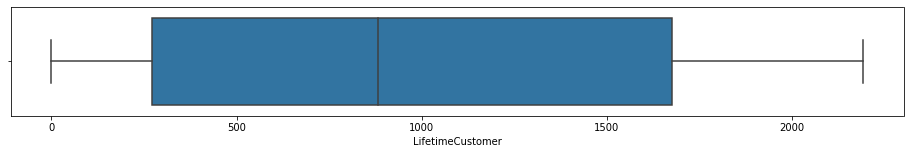

count    7043.000000
mean      985.996166
std       747.587844
min         0.000000
25%       273.000000
50%       883.000000
75%      1676.000000
max      2191.000000
Name: LifetimeCustomer, dtype: float64

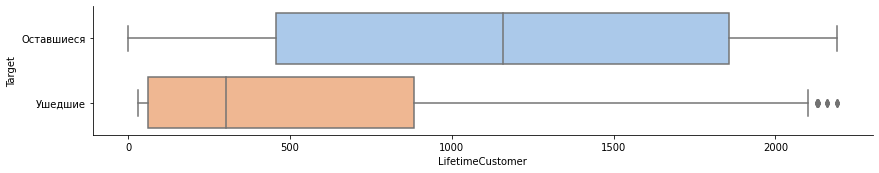

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: LifetimeCustomer, dtype: float64

In [23]:
visual_alldata_catplot('LifetimeCustomer')
visual_data_catplot('LifetimeCustomer')

В среднем пользователем является абонентом 883 дня, ушедшие в среднем являются абонентами 304 дня.

In [24]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Target', 'LifetimeCustomer', 'Class']
phik_overview = (f_df.drop(['CustomerID','BeginDate','EndDate'],axis=1)
                    .phik_matrix(interval_cols=interval_cols))

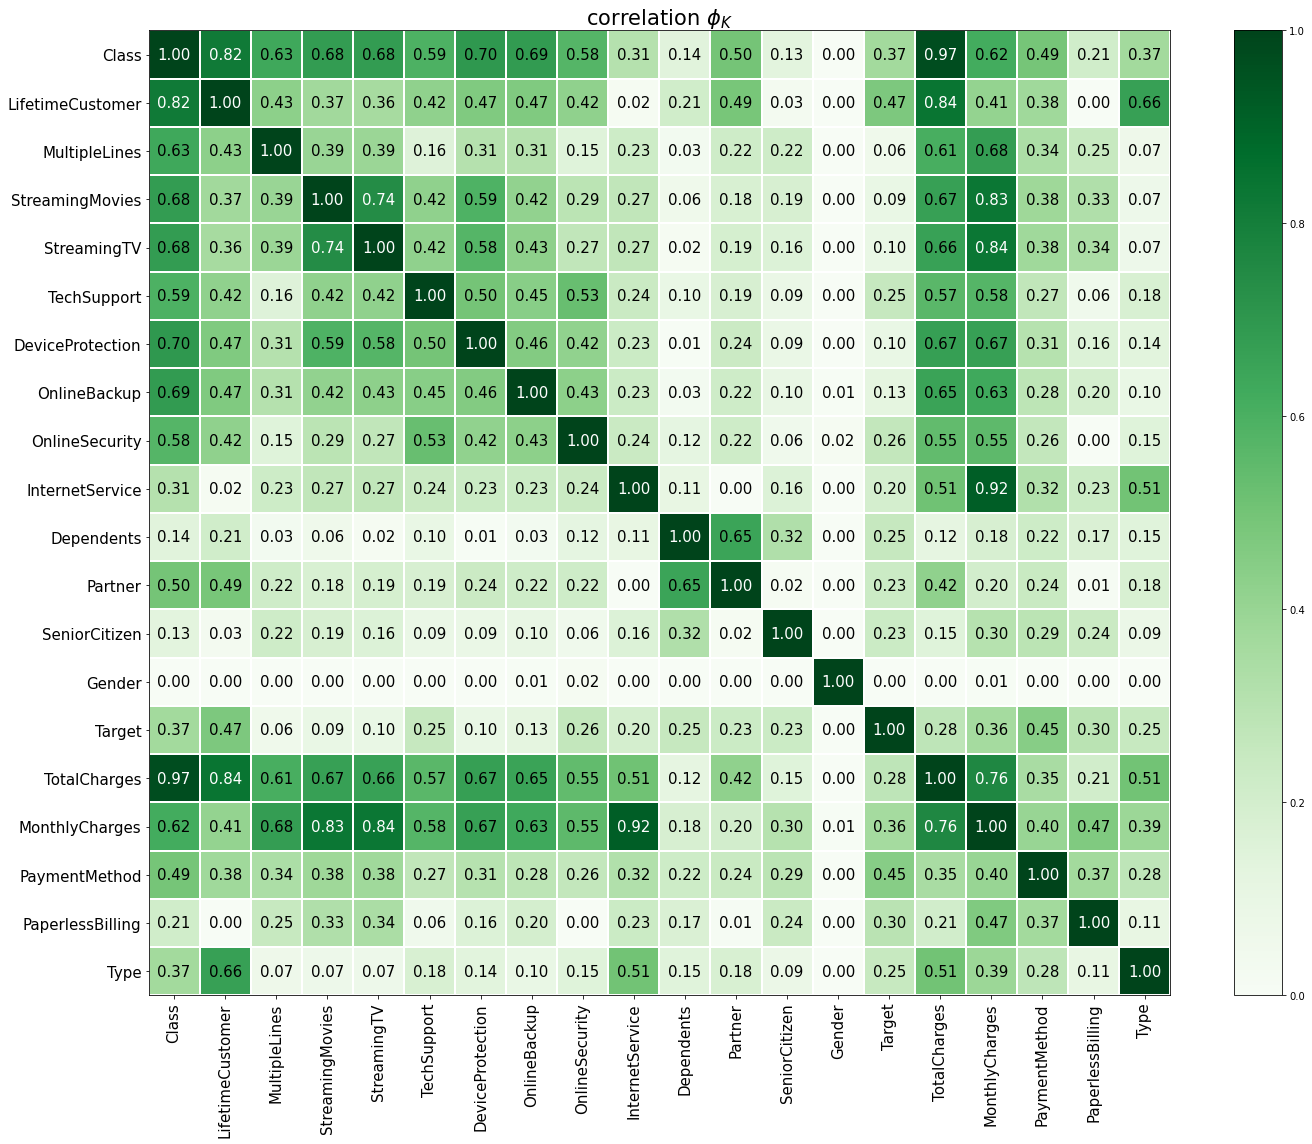

In [25]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 16))
plt.tight_layout()

Анализ зависимостей показывает, что добавленный реквизит Класс, а так же реквизиты Итоговый платеж и Ежемесячный платеж имеет высокую кореляцию с другими параметрами >.7, остальные параметры имеют кореляцию  <.7, что можно считать не влияющим на построение модели.

Поэтому следует изучить влияние данных параметров на модель машинного обучения. 

### Выводы

- Большая часть ушедших использует услуги с ежемесячной оплатой.
- Большая часть ушедших использует безналичный расчет
- Большая часть ушедших использует электронные чеки как способ оплаты
- Пол не влият на вероятность ухода
- Большая часть ушедших имеет пенсионный статус
- У большей части ушедших нет супруга
- У большей части ушедших есть иждивенцы


- Большая часть ушедших использует оптоволоконный интернет
- Большая часть ушедших не используется онлайн защиту
- Большая часть ушедших не использует онлайн резервное копирование
- Большая часть ушедших не используется защиту устройств
- Большая часть ушедших не использует тех поддержку.
- Чуть больше половины ушедших не используется ТВ
- Чуть больше половины ушедших не испольуется сервис кино
- Чуть больше половины ушедших не использую множественную линию


- Большая часть ушедших относится к 1 категории, которая характеризуется средним ежемесячным платежом в 51 у.е., общим доходом 381 у.е. и временем жизни клиента в 273 дня

- В среднем ушедший принес компании от 134 до 2331 у.е., средний пользователь приносит от 398 до 3786 у.е
- В среднем пользователь платит от 35 до 89 у.е. в месяц, ушедшие платят от 56 до 94 у.е.
- В среднем пользователем является абонентом 883 дня, ушедшие в среднем являются абонентами 304 дня.

Анализ зависимостей показывает, что добавленный реквизит Класс, а так же реквизиты Итоговый платеж и Ежемесячный платеж имеет высокую кореляцию с другими параметрами >.7, остальные параметры имеют кореляцию  <.7, что можно считать не влияющим на построение модели.

Поэтому следует изучить влияние данных параметров на модель машинного обучения. 

## Поиск модели

In [26]:
data = []

In [27]:
#encode
e_df = f_df.copy()

### Кодирование данных

In [28]:
encode_list =['Class','Type','PaperlessBilling','PaymentMethod',
              'Gender','Partner','Dependents','InternetService',
              'OnlineSecurity','OnlineBackup','DeviceProtection',
              'TechSupport','StreamingTV','StreamingMovies','MultipleLines','SeniorCitizen']

e_df = pd.get_dummies(e_df, columns = encode_list , prefix_sep = "_", drop_first=True)
e_df.head()

CustomerID  BeginDate    EndDate  MonthlyCharges  TotalCharges  Target  \
0  7590-VHVEG 2020-01-01 2020-02-01           29.85         29.85       0   
1  5575-GNVDE 2017-04-01 2020-02-01           56.95       1889.50       0   
2  3668-QPYBK 2019-10-01 2019-12-01           53.85        108.15       1   
3  7795-CFOCW 2016-05-01 2020-02-01           42.30       1840.75       0   
4  9237-HQITU 2019-09-01 2019-11-01           70.70        151.65       1   

   LifetimeCustomer  Class_1  Class_2  Class_3  ...  \
0                31        0        0        0  ...   
1              1036        0        1        0  ...   
2                61        0        0        0  ...   
3              1371        0        1        0  ...   
4                61        0        0        0  ...   

   InternetService_Fiber optic  InternetService_No service  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            1                           0   

   OnlineSecurity_Yes  OnlineBackup_Yes  DeviceProtection_Yes  \
0                   0                 1                     0   
1                   1                 0                     1   
2                   1                 1                     0   
3                   1                 0                     1   
4                   0                 0                     0   

   TechSupport_Yes  StreamingTV_Yes  StreamingMovies_Yes  MultipleLines_Yes  \
0                0                0                    0                  0   
1                0                0                    0                  0   
2                0                0                    0                  0   
3                1                0                    0                  0   
4                0                0                    0                  0   

   SeniorCitizen_True  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 29 columns]

### Разделение данных

In [29]:
e_df = e_df.drop(['CustomerID','BeginDate','EndDate'],axis=1)

(features_train, features_test, 
        target_train, target_test) = train_test_split(e_df.drop('Target', axis=1), 
                                                      e_df['Target'], test_size=.25, 
                                                      random_state=281122,
                                                      stratify=e_df['Target'])
    
display(features_train.shape)
display(features_test.shape)

(5282, 25)

(1761, 25)

In [30]:
#scaler
(s_features_train, s_features_test, 
        s_target_train, s_target_test) = train_test_split(e_df.drop('Target', axis=1), 
                                                      e_df['Target'], test_size=.25, 
                                                      random_state=281122,
                                                      stratify=e_df['Target'])
    
display(s_features_train.shape)
display(s_features_test.shape)

(5282, 25)

(1761, 25)

### Масштабирование данных

In [31]:
encode_list = ['MonthlyCharges','TotalCharges','LifetimeCustomer']
scaler = StandardScaler()
scaler = scaler.fit(s_features_train[encode_list])
s_features_train[encode_list] = scaler.transform(s_features_train[encode_list])
s_features_test[encode_list] = scaler.transform(s_features_test[encode_list])

In [32]:
data_voc = {'Non scaled': [features_train, features_test, target_train, target_test], 
            'Scaled': [s_features_train, s_features_test, s_target_train, s_target_test],
            #WithOut data 'MonthlyCharges', 'TotalCharges', 'Class' Non Scaled
            #проверим модель без параметров с высокой корреляцией, без масштабирования
            'WONS':  [features_train.drop(['MonthlyCharges', 'TotalCharges', 'Class_1','Class_2','Class_3'],axis=1), 
                      features_test.drop(['MonthlyCharges', 'TotalCharges', 'Class_1','Class_2','Class_3'],axis=1), 
                      target_train, target_test], 
            #WithOut data 'MonthlyCharges', 'TotalCharges', 'Class' scaled
            #проверим модель без параметров с высокой корреляцией, с масштабированием
            'WO':  [s_features_train.drop(['MonthlyCharges', 'TotalCharges', 'Class_1','Class_2','Class_3'],axis=1),
                    s_features_test.drop(['MonthlyCharges', 'TotalCharges', 'Class_1','Class_2','Class_3'],axis=1),
                    s_target_train, s_target_test]}

### Обучение модели

In [33]:
#процедура обучения моделей
def learn_model(imodel, rf_grid, model_name, data):
    best_param = []
    
    for elem in data_voc:
        
        model = GridSearchCV(imodel, rf_grid[elem], scoring = 'roc_auc', cv=5, verbose=1)
    
        model.fit(data_voc[elem][0], data_voc[elem][2])
        
        data.append([model_name,
                 elem,
                 model.best_score_,
                 model.best_params_,
                 model])
            
        best_param.append([elem, model.best_params_])
        
    for elem in best_param:
        print(elem)


### Logistic Regression

In [34]:
%%time

#Wall time: 33min 46s
params ={'C':[float(x) for x in np.linspace(0.01, 10.0, num = 20)],
         'fit_intercept':[True,False],
         'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
         'warm_start':[True],
         'max_iter':[5000],
         'random_state':[281122]}

#Wall time: 23.6 s
rf_grid = {'Non scaled': {'C': [0.5357894736842106], 'fit_intercept': [True], 'max_iter': [5000], 
                          'random_state': [281122], 'solver': ['newton-cg'], 'warm_start': [True]}, 
            'Scaled': {'C': [0.5357894736842106], 'fit_intercept': [True], 'max_iter': [5000], 
                       'random_state': [281122], 'solver': ['sag'], 'warm_start': [True]},
            'WONS': {'C': [1.5873684210526318], 'fit_intercept': [True], 'max_iter': [5000], 
                     'random_state': [281122], 'solver': ['liblinear'], 'warm_start': [True]}, 
            'WO':  {'C': [0.5357894736842106], 'fit_intercept': [True], 'max_iter': [5000], 
                    'random_state': [281122], 'solver': ['newton-cg'], 'warm_start': [True]}}


learn_model(LogisticRegression(), rf_grid, 'Logistic Regression', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'C': 0.5357894736842106, 'fit_intercept': True, 'max_iter': 5000, 'random_state': 281122, 'solver': 'newton-cg', 'warm_start': True}]
['Scaled', {'C': 0.5357894736842106, 'fit_intercept': True, 'max_iter': 5000, 'random_state': 281122, 'solver': 'sag', 'warm_start': True}]
['WONS', {'C': 1.5873684210526318, 'fit_intercept': True, 'max_iter': 5000, 'random_state': 281122, 'solver': 'liblinear', 'warm_start': True}]
['WO', {'C': 0.5357894736842106, 'fit_intercept': True, 'max_iter': 5000, 'random_state': 281122, 'solver': 'newton-cg', 'warm_start': True}]
CPU times: user 10.2 s, sys: 13.4 s, total: 23.6 s
Wall time: 23.6 s


### Nearest Neighbors

In [35]:
%%time

#Wall time: 35min 22s
params ={'n_neighbors':[int(x) for x in np.linspace(5, 100, num = 20)], #num 20
         'weights':['uniform','distance'],
         'algorithm':['auto','ball_tree','kd_tree','brute'],
         'metric':['minkowski','cityblock','cosine','euclidean','haversine','l1','l2','manhattan']}

#Wall time: 1.81 s
rf_grid = {'Non scaled': {'algorithm': ['ball_tree'], 'metric': ['cityblock'], 
                          'n_neighbors': [65], 'weights': ['uniform']}, 
            'Scaled': {'algorithm': ['kd_tree'], 'metric': ['cityblock'], 
                       'n_neighbors': [95], 'weights': ['uniform']},
            'WONS': {'algorithm': ['ball_tree'], 'metric': ['minkowski'], 
                     'n_neighbors': [10], 'weights': ['uniform']}, 
            'WO':  {'algorithm': ['kd_tree'], 'metric': ['minkowski'], 
                    'n_neighbors': [95], 'weights': ['uniform']}}


learn_model(KNeighborsClassifier(), rf_grid, 'Nearest Neighbors', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'algorithm': 'ball_tree', 'metric': 'cityblock', 'n_neighbors': 65, 'weights': 'uniform'}]
['Scaled', {'algorithm': 'kd_tree', 'metric': 'cityblock', 'n_neighbors': 95, 'weights': 'uniform'}]
['WONS', {'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'uniform'}]
['WO', {'algorithm': 'kd_tree', 'metric': 'minkowski', 'n_neighbors': 95, 'weights': 'uniform'}]
CPU times: user 1.75 s, sys: 45.6 ms, total: 1.79 s
Wall time: 1.81 s


### SVC (gamma = list)

In [36]:
%%time

#Wall time: 5h 34min 9s
params ={'C':[float(x) for x in np.linspace(0.01, 1, num = 10)], 
         'kernel':['linear', 'rbf', 'sigmoid'],
         'gamma':['scale','auto'], # int(x) for x in np.linspace(1, 10, num = 2) step 1
         'random_state':[281122]}

#Wall time: 9min 30s
rf_grid = {'Non scaled': {'C': [0.01], 'gamma': ['scale'], 'kernel': ['linear'], 'random_state': [281122]}, 
            'Scaled': {'C': [0.12], 'gamma': ['auto'], 'kernel': ['sigmoid'], 'random_state': [281122]},
            'WONS': {'C': [1.0], 'gamma': ['auto'], 'kernel': ['rbf'], 'random_state': [281122]}, 
            'WO':  {'C': [0.23], 'gamma': ['auto'], 'kernel': ['sigmoid'], 'random_state': [281122]}}

learn_model(SVC(), rf_grid, 'SVC', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'random_state': 281122}]
['Scaled', {'C': 0.12, 'gamma': 'auto', 'kernel': 'sigmoid', 'random_state': 281122}]
['WONS', {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 281122}]
['WO', {'C': 0.23, 'gamma': 'auto', 'kernel': 'sigmoid', 'random_state': 281122}]
CPU times: user 9min 27s, sys: 1.76 s, total: 9min 29s
Wall time: 9min 30s


### Gaussian Process

In [37]:
%%time

params ={'warm_start':[True],
          'n_restarts_optimizer':[int(x) for x in np.linspace(1, 10, num = 10)],
           'random_state':[281122]}

#Wall time: 14min 4s
rf_grid = {'Non scaled': {'n_restarts_optimizer': [1], 'random_state': [281122], 'warm_start': [True]}, 
            'Scaled': {'n_restarts_optimizer': [1], 'random_state': [281122], 'warm_start': [True]},
            'WONS': {'n_restarts_optimizer': [1], 'random_state': [281122], 'warm_start': [True]}, 
            'WO':  {'n_restarts_optimizer': [1], 'random_state': [281122], 'warm_start': [True]}}

learn_model(GaussianProcessClassifier(), rf_grid, 'Gaussian Process', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'n_restarts_optimizer': 1, 'random_state': 281122, 'warm_start': True}]
['Scaled', {'n_restarts_optimizer': 1, 'random_state': 281122, 'warm_start': True}]
['WONS', {'n_restarts_optimizer': 1, 'random_state': 281122, 'warm_start': True}]
['WO', {'n_restarts_optimizer': 1, 'random_state': 281122, 'warm_start': True}]
CPU times: user 10min 16s, sys: 3min 46s, total: 14min 3s
Wall time: 14min 4s


### Decision Tree

In [38]:
%%time

#Wall time: 1min 39s
params ={'criterion':['gini','entropy','log_loss'],
          'splitter':['best','random'],
          'max_depth':[int(x) for x in np.linspace(1, 10, num = 10)],
          'min_samples_split':[int(x) for x in np.linspace(1, 10, num = 10)],
          'min_samples_leaf':[int(x) for x in np.linspace(1, 10, num = 10)],
          'random_state':[281122]}

#Wall time: 433 ms
rf_grid = {'Non scaled': {'criterion': ['entropy'], 'max_depth': [7], 'min_samples_leaf': [1], 
                          'min_samples_split': [9], 'random_state': [281122], 'splitter': ['best']}, 
            'Scaled': {'criterion': ['entropy'], 'max_depth': [7], 'min_samples_leaf': [1], 
                       'min_samples_split': [9], 'random_state': [281122], 'splitter': ['best']},
            'WONS': {'criterion': ['gini'], 'max_depth': [6], 'min_samples_leaf': [2], 
                     'min_samples_split': [2], 'random_state': [281122], 'splitter': ['best']}, 
            'WO':  {'criterion': ['gini'], 'max_depth': [6], 'min_samples_leaf': [2], 
                    'min_samples_split': [2], 'random_state': [281122], 'splitter': ['best']}}

learn_model(DecisionTreeClassifier(), rf_grid, 'Decision Tree', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 9, 'random_state': 281122, 'splitter': 'best'}]
['Scaled', {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 9, 'random_state': 281122, 'splitter': 'best'}]
['WONS', {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 281122, 'splitter': 'best'}]
['WO', {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 281122, 'splitter': 'best'}]
CPU times: user 360 ms, sys: 17.8 ms, total: 378 ms
Wall time: 433 ms


### Random Forest

In [39]:
%%time

#Wall time: 10min 13s
params ={'n_estimators':[int(x) for x in np.linspace(100, 1000, num = 10)],
          'criterion':['gini','entropy','log_loss'],
          'warm_start':[True],
          'max_depth':[int(x) for x in np.linspace(1, 10, num = 10)],
          'random_state':[281122]}

#Wall time: 25.4 s
rf_grid = {'Non scaled': {'criterion': ['entropy'], 'max_depth': [8], 
                          'n_estimators': [500], 'random_state': [281122], 'warm_start': [True]}, 
            'Scaled': {'criterion': ['entropy'], 'max_depth': [8], 
                       'n_estimators': [100], 'random_state': [281122], 'warm_start': [True]},
            'WONS': {'criterion': ['entropy'], 'max_depth': [7], 
                     'n_estimators': [400], 'random_state': [281122], 'warm_start': [True]}, 
            'WO':  {'criterion': ['entropy'], 'max_depth': [7], 
                    'n_estimators': [400], 'random_state': [281122], 'warm_start': [True]}}

learn_model(RandomForestClassifier(), rf_grid, 'Random Forest', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 500, 'random_state': 281122, 'warm_start': True}]
['Scaled', {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100, 'random_state': 281122, 'warm_start': True}]
['WONS', {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 400, 'random_state': 281122, 'warm_start': True}]
['WO', {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 400, 'random_state': 281122, 'warm_start': True}]
CPU times: user 24.8 s, sys: 357 ms, total: 25.2 s
Wall time: 25.4 s


### Neural Net MLPClassifier()

In [40]:
%%time

#Wall time: 57min 43s
params ={'activation':['identity','logistic','tanh','relu'],
          'solver':['lbfgs','sgd','adam'],
          'learning_rate':['constant','invscaling','adaptive'],
          'warm_start':[True],
          'power_t':[x for x in np.linspace(0.1, 1, num = 10)],
          'random_state':[281122]}

rf_grid = {'Non scaled': {'activation': ['logistic'], 'learning_rate': ['constant'], 
                          'power_t': [0.1], 'random_state': [281122], 'solver': ['lbfgs'], 'warm_start': [True]}, 
            'Scaled': {'activation': ['identity'], 'learning_rate': ['constant'], 
                       'power_t': [0.1], 'random_state': [281122], 'solver': ['lbfgs'], 'warm_start': [True]},
            'WONS': {'activation': ['logistic'], 'learning_rate': ['constant'], 
                     'power_t': [0.1], 'random_state': [281122], 'solver': ['adam'], 'warm_start': [True]}, 
            'WO':  {'activation': ['tanh'], 'learning_rate': ['constant'], 
                    'power_t': [0.1], 'random_state': [281122], 'solver': ['adam'], 'warm_start': [True]}}

learn_model(MLPClassifier(), rf_grid, 'Neural Net', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['Non scaled', {'activation': 'logistic', 'learning_rate': 'constant', 'power_t': 0.1, 'random_state': 281122, 'solver': 'lbfgs', 'warm_start': True}]
['Scaled', {'activation': 'identity', 'learning_rate': 'constant', 'power_t': 0.1, 'random_state': 281122, 'solver': 'lbfgs', 'warm_start': True}]
['WONS', {'activation': 'logistic', 'learning_rate': 'constant', 'power_t': 0.1, 'random_state': 281122, 'solver': 'adam', 'warm_start': True}]
['WO', {'activation': 'tanh', 'learning_rate': 'constant', 'power_t': 0.1, 'random_state': 281122, 'solver': 'adam', 'warm_start': True}]
CPU times: user 6min 30s, sys: 8min 28s, total: 14min 59s
Wall time: 15min 2s


/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### AdaBoost

In [41]:
%%time
#Wall time: 15min 54s
params ={'n_estimators':[int(x) for x in np.linspace(1, 100, num = 11)],
          'learning_rate':[x for x in np.linspace(0.1, 5, num = 50)],
          'algorithm':['SAMME','SAMME.R'],
          'random_state':[281122]}

# Wall time: 9.09 s
rf_grid = {'Non scaled': {'algorithm': ['SAMME.R'], 'learning_rate': [1.6], 
                          'n_estimators': [100], 'random_state': [281122]}, 
            'Scaled': {'algorithm': ['SAMME.R'], 'learning_rate': [1.6], 
                       'n_estimators': [100], 'random_state': [281122]},
            'WONS': {'algorithm': ['SAMME.R'], 'learning_rate': [1.8000000000000003], 
                     'n_estimators': [100], 'random_state': [281122]}, 
            'WO':  {'algorithm': ['SAMME.R'], 'learning_rate': [1.8000000000000003], 
                    'n_estimators': [100], 'random_state': [281122]}}

learn_model(AdaBoostClassifier(), rf_grid, 'AdaBoost', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'algorithm': 'SAMME.R', 'learning_rate': 1.6, 'n_estimators': 100, 'random_state': 281122}]
['Scaled', {'algorithm': 'SAMME.R', 'learning_rate': 1.6, 'n_estimators': 100, 'random_state': 281122}]
['WONS', {'algorithm': 'SAMME.R', 'learning_rate': 1.8000000000000003, 'n_estimators': 100, 'random_state': 281122}]
['WO', {'algorithm': 'SAMME.R', 'learning_rate': 1.8000000000000003, 'n_estimators': 100, 'random_state': 281122}]
CPU times: user 8.75 s, sys: 259 ms, total: 9.01 s
Wall time: 9.09 s


### Naive Bayes GaussianNB()

In [42]:
%%time

#Wall time: 583 ms
params ={}


# Wall time: 4.77 s
rf_grid = {'Non scaled': params, 
            'Scaled': params,
            'WONS': params, 
            'WO':  params}

learn_model(AdaBoostClassifier(), rf_grid, 'GaussianNB', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {}]
['Scaled', {}]
['WONS', {}]
['WO', {}]
CPU times: user 4.63 s, sys: 128 ms, total: 4.76 s
Wall time: 4.77 s


### Gradient Boosting

In [43]:
%%time

#Wall time: 7h 27min 20s
params ={'loss':['log_loss','deviance','exponential'],
         'n_estimators':[int(x) for x in np.linspace(100, 1000, num = 10)],
         'criterion':['friedman_mse','squared_error','squared_error'],
         'max_depth':[int(x) for x in np.linspace(1, 10, num = 10)],
         'random_state':[281122],
         'warm_start':[True]}

# Wall time: 1min 21s
rf_grid = {'Non scaled': {'criterion': ['squared_error'], 'loss': ['log_loss'], 'max_depth': [2], 
                          'n_estimators': [1000], 'random_state': [281122], 'warm_start': [True]}, 
            'Scaled': {'criterion': ['squared_error'], 'loss': ['log_loss'], 'max_depth': [2], 
                       'n_estimators': [1000], 'random_state': [281122], 'warm_start': [True]},
            'WONS': {'criterion': ['friedman_mse'], 'loss': ['log_loss'], 'max_depth': [2], 
                     'n_estimators': [1000], 'random_state': [281122], 'warm_start': [True]}, 
            'WO':  {'criterion': ['friedman_mse'], 'loss': ['log_loss'], 'max_depth': [2], 
                    'n_estimators': [1000], 'random_state': [281122], 'warm_start': [True]}}


learn_model(GradientBoostingClassifier(), rf_grid, 'Gradient Boosting', data)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
['Non scaled', {'criterion': 'squared_error', 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 1000, 'random_state': 281122, 'warm_start': True}]
['Scaled', {'criterion': 'squared_error', 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 1000, 'random_state': 281122, 'warm_start': True}]
['WONS', {'criterion': 'friedman_mse', 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 1000, 'random_state': 281122, 'warm_start': True}]
['WO', {'criterion': 'friedman_mse', 'loss': 'log_loss', 'max_depth': 2, 'n_estimators': 1000, 'random_state': 281122, 'warm_start': True}]
CPU times: user 1min 19s, sys: 1.77 s, total: 1min 21s
Wall time: 1min 21s


## Выбор модели

Model   Data type    Result  \
39    Gradient Boosting          WO  0.942216   
38    Gradient Boosting        WONS  0.942216   
36    Gradient Boosting  Non scaled  0.908209   
37    Gradient Boosting      Scaled  0.907973   
10                  SVC        WONS  0.900126   
6     Nearest Neighbors        WONS  0.886574   
31             AdaBoost          WO  0.880269   
30             AdaBoost        WONS  0.880269   
14     Gaussian Process        WONS  0.876081   
28             AdaBoost  Non scaled  0.863166   
29             AdaBoost      Scaled  0.863127   
35           GaussianNB          WO  0.860085   
34           GaussianNB        WONS  0.860085   
32           GaussianNB  Non scaled  0.855681   
33           GaussianNB      Scaled  0.855679   
20        Random Forest  Non scaled  0.852637   
21        Random Forest      Scaled  0.851581   
23        Random Forest          WO  0.851133   
22        Random Forest        WONS  0.851126   
18        Decision Tree        WONS  0.840206   
19        Decision Tree          WO  0.840206   
26           Neural Net        WONS  0.838542   
25           Neural Net      Scaled  0.833995   
0   Logistic Regression  Non scaled  0.833857   
1   Logistic Regression      Scaled  0.833781   
27           Neural Net          WO  0.833701   
3   Logistic Regression          WO  0.832101   
2   Logistic Regression        WONS  0.831978   
7     Nearest Neighbors          WO  0.831659   
5     Nearest Neighbors      Scaled  0.829049   
16        Decision Tree  Non scaled  0.828477   
17        Decision Tree      Scaled  0.828477   
11                  SVC          WO  0.827029   
9                   SVC      Scaled  0.823578   
15     Gaussian Process          WO  0.822897   
13     Gaussian Process      Scaled  0.817354   
8                   SVC  Non scaled  0.814586   
24           Neural Net  Non scaled  0.806281   
4     Nearest Neighbors  Non scaled  0.803817   
12     Gaussian Process  Non scaled  0.627731   

                                          Best_params  \
39  {'criterion': 'friedman_mse', 'loss': 'log_los...   
38  {'criterion': 'friedman_mse', 'loss': 'log_los...   
36  {'criterion': 'squared_error', 'loss': 'log_lo...   
37  {'criterion': 'squared_error', 'loss': 'log_lo...   
10  {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf', '...   
6   {'algorithm': 'ball_tree', 'metric': 'minkowsk...   
31  {'algorithm': 'SAMME.R', 'learning_rate': 1.80...   
30  {'algorithm': 'SAMME.R', 'learning_rate': 1.80...   
14  {'n_restarts_optimizer': 1, 'random_state': 28...   
28  {'algorithm': 'SAMME.R', 'learning_rate': 1.6,...   
29  {'algorithm': 'SAMME.R', 'learning_rate': 1.6,...   
35                                                 {}   
34                                                 {}   
32                                                 {}   
33                                                 {}   
20  {'criterion': 'entropy', 'max_depth': 8, 'n_es...   
21  {'criterion': 'entropy', 'max_depth': 8, 'n_es...   
23  {'criterion': 'entropy', 'max_depth': 7, 'n_es...   
22  {'criterion': 'entropy', 'max_depth': 7, 'n_es...   
18  {'criterion': 'gini', 'max_depth': 6, 'min_sam...   
19  {'criterion': 'gini', 'max_depth': 6, 'min_sam...   
26  {'activation': 'logistic', 'learning_rate': 'c...   
25  {'activation': 'identity', 'learning_rate': 'c...   
0   {'C': 0.5357894736842106, 'fit_intercept': Tru...   
1   {'C': 0.5357894736842106, 'fit_intercept': Tru...   
27  {'activation': 'tanh', 'learning_rate': 'const...   
3   {'C': 0.5357894736842106, 'fit_intercept': Tru...   
2   {'C': 1.5873684210526318, 'fit_intercept': Tru...   
7   {'algorithm': 'kd_tree', 'metric': 'minkowski'...   
5   {'algorithm': 'kd_tree', 'metric': 'cityblock'...   
16  {'criterion': 'entropy', 'max_depth': 7, 'min_...   
17  {'criterion': 'entropy', 'max_depth': 7, 'min_...   
11  {'C': 0.23, 'gamma': 'auto', 'kernel': 'sigmoi...   
9   {'C': 0.12, 'gamma': 'auto', 'kernel': 'sigmoi...   
15  {'n_resta

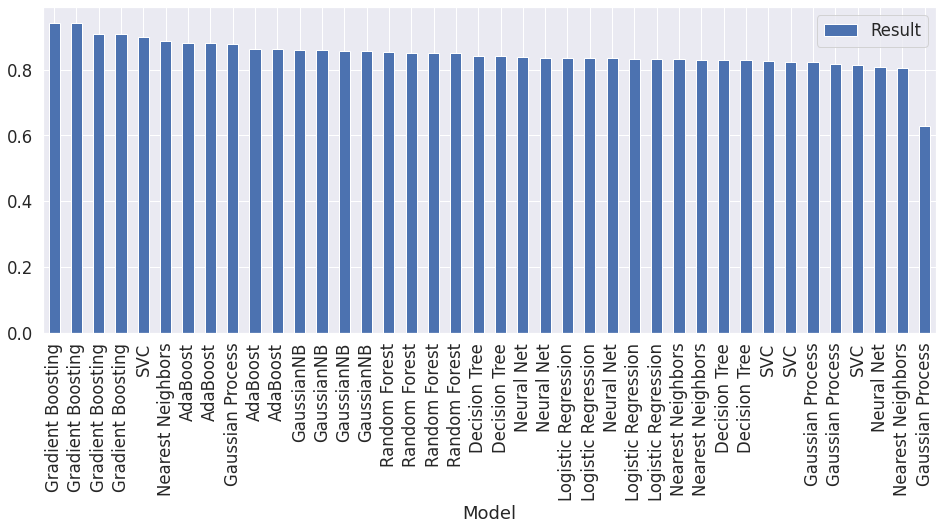

In [59]:
df_ml = pd.DataFrame(data, columns=['Model','Data type','Result','Best_params', 'ExecuteModel'])
df_ml.sort_values('Result', ascending=False, inplace=True)
df_ml.plot(x='Model',y='Result',kind='bar', figsize=(16,6))
df_ml

- Все модели показали результат от 0.62 до 0.94, что можно считать достаточно хорошим показателем. При этом большая часть моделей показала результат >.8
- Наилучший результат показала модель Gradient Boosting с результатом в 0.94 с удаленными коллинеарными данными. Масштабирование не оказало существенного влияния на результат без коллинеарных данных.

## Порверка лучшей модели

### Тестовая выборка

In [45]:
features_train = data_voc['WO'][0]
features_test  = data_voc['WO'][1]
target_train = data_voc['WO'][2]
target_test  = data_voc['WO'][3]

model = GradientBoostingClassifier(criterion = 'friedman_mse', loss= 'log_loss', 
                               max_depth = 2, n_estimators = 1000, random_state = 281122,  
                               warm_start = True)

model.fit(features_train, target_train)
prediction = model.predict_proba(features_test)[:,1]
fpr, tpr, thresholds = roc_curve(target_test, prediction, pos_label=1)

### Выводы

ROC-AUC:  0.9538497562460905


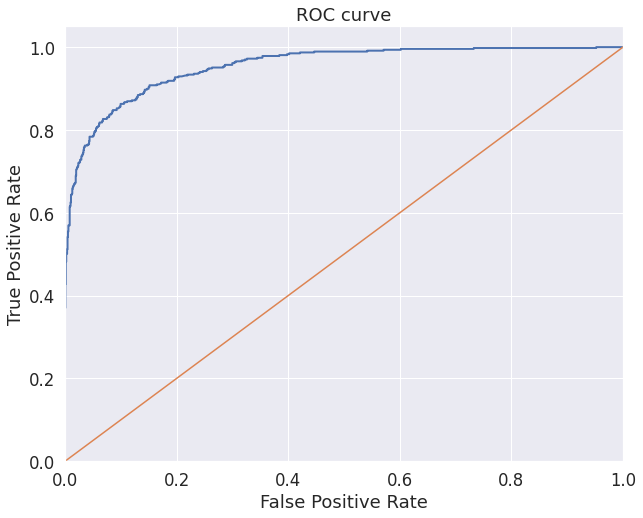

In [46]:
print('ROC-AUC: ',roc_auc_score(target_test, prediction))

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

На обучающей выборке модель градиентного бустинга показала результаты ROC-AUC 0.94, на тестовой выборке получены результаты ROC-AUC 0.95

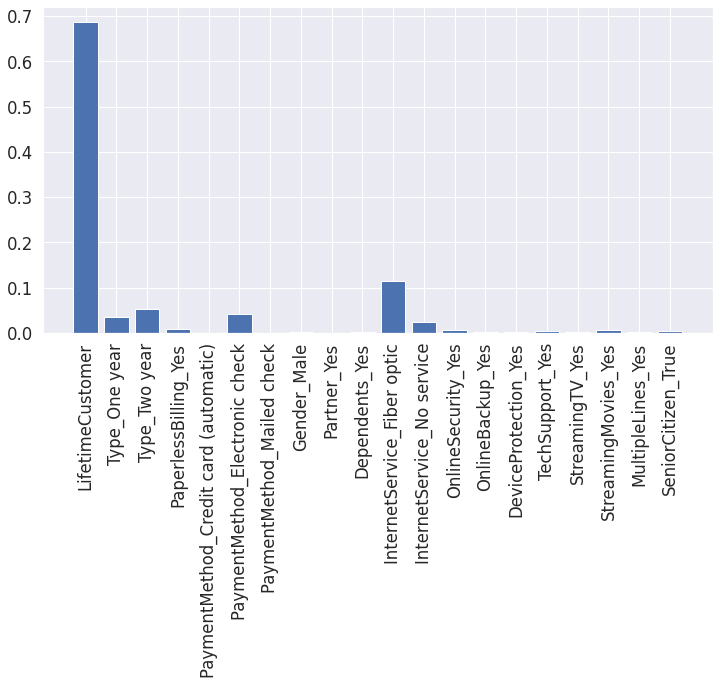

In [47]:
plt.figure(figsize=(12,6))
plt.bar(features_train.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Наиболее значимым параметром, модель определила показатели LifetimeCustomer, InternetService, Type, PaymentMethod. Остальные параметры имеют сильно меньшее влияние на модель

## Выводы по проекту

Исходные данные:
- Во всех таблицах были переименованы колонки customerID на CustomerID
- В таблице personal была переименована колонка gender на Gender
- Были преобразованы данные EndDate к типу Дата
- Были преобразованы данные TotalCharges к Типу float
- Были преобразованы данные SeniorCitizen к типу Boolean
- Был добавлен целевой признак в колонку Target

Анализ данных:
- Большая часть ушедших использует услуги с ежемесячной оплатой.
- Большая часть ушедших использует безналичный расчет
- Большая часть ушедших использует электронные чеки как способ оплаты
- Пол не влият на вероятность ухода
- Большая часть ушедших имеет пенсионный статус
- У большей части ушедших нет супруга
- У большей части ушедших есть иждивенцы


- Большая часть ушедших использует оптоволоконный интернет
- Большая часть ушедших не используется онлайн защиту
- Большая часть ушедших не использует онлайн резервное копирование
- Большая часть ушедших не используется защиту устройств
- Большая часть ушедших не использует тех поддержку.
- Чуть больше половины ушедших не используется ТВ
- Чуть больше половины ушедших не испольуется сервис кино
- Чуть больше половины ушедших не использую множественную линию


- Большая часть ушедших относится к 1 категории, которая характеризуется средним ежемесячным платежом в 51 у.е., общим доходом 381 у.е. и временем жизни клиента в 273 дня


- В среднем ушедший принес компании от 134 до 2331 у.е., средний пользователь приносит от 398 до 3786 у.е
- В среднем пользователь платит от 35 до 89 у.е. в месяц, ушедшие платят от 56 до 94 у.е.
- В среднем пользователем является абонентом 883 дня, ушедшие в среднем являются абонентами 304 дня.

Обучение и выбор модели:
- Все модели показали результат от 0.62 до 0.94, что можно считать достаточно хорошим показателем. При этом большая часть моделей показала результат >.8
- Наилучший результат показала модель Gradient с результатом в 0.94 с удаленными коллинеарными данными. Масштабирование не оказало существенного влияния на результат без коллинеарных данных.
- На обучающей выборке модель градиентного бустинга показала результаты ROC-AUC 0.94, на тестовой выборке получены результаты ROC-AUC 0.95
- Наиболее значимым параметром, модель определила показатели LifetimeCustomer, InternetService, Type, PaymentMethod. Остальные параметры имеют сильно меньшее влияние на модель